In [1]:
import sys
sys.path.append('..')
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import sklearn
from sklearn import metrics
from cluster_analysis import C_HDBSCAN, C_GaussianMixture
from evaluation_metrics import ClusterEvalIoU, ClusterEvalMode
from recurse_cluster import RecursiveCluster
from pingouin import multivariate_normality

In [2]:
df = pd.read_hdf('../data/m12f_cluster_data_large_mass_large_cluster_v2.h5', key='star')
df['cluster_id_name'] = np.array([f'cluster {id}' for id in df['cluster_id'].to_numpy()])
#chosen_cluster_ids = np.random.choice(np.arange(1,27), 26, replace=False)
#chosen_ids = np.argwhere(df['cluster_id'].isin(chosen_cluster_ids).to_numpy())[:,0]
chosen_ids = np.random.choice(len(df), min(len(df), 10000))
df = df.iloc[chosen_ids].copy()
df = df.reset_index()
df.head()

,index,Unnamed: 0.2,Unnamed: 0,Unnamed: 0.1,feH,id_stars,radial_distance_stars,redshift_stars,snap_list_stars,star_mass,...,pstar,kstar,lxstar,lystar,lzstar,apostar,peristar,eccstar,zmaxstar,cluster_id_name
0,458002,458002,458002,458002,-1.556742,14809296,3.786520,5.000000,67,4703.701411,...,-234438.060133,31725.135281,-680.397001,65.331875,420.347327,4.977036,2.197419,0.387433,4.187208,cluster 15
1,306488,306488,306488,306488,-0.934090,5110531,11.587580,0.799427,312,5073.704293,...,-160236.387665,63809.005863,59.757199,-1334.040507,187.349856,37.624447,4.566144,0.783547,33.207100,cluster 22
2,322468,322468,322468,322468,-1.005718,8245005,9.720855,0.799427,312,5154.492395,...,-177346.109292,62313.446311,-450.139500,-1445.246644,954.719934,26.628347,2.744199,0.813145,18.068226,cluster 22
3,403142,403142,403142,403142,-1.143487,13663988,3.600455,3.000000,120,5268.952530,...,-240307.324497,19185.855836,171.552015,-263.031583,-152.287878,4.629294,0.611681,0.766577,3.563884,cluster 3
4,331011,331011,331011,331011,-1.420494,9581553,14.350273,0.799427,312,4898.112381,...,-157316.017926,54222.464553,-1505.508100,755.427726,2518.528823,32.912159,5.914997,0.695316,11.140133,cluster 22


In [3]:
np.unique(df['redshift_stars'])

array([0.30020699, 0.3986637 , 0.59796441, 0.70189703, 0.79942691,
       0.89728099, 1.        , 1.5       , 2.        , 2.5056181 ,
       3.        , 4.        , 5.        , 6.        ])

In [113]:
df = df.loc[(df['redshift_stars']==1.5) | (df['redshift_stars']==2)]

In [114]:
df['redshift_stars_names'] = np.array([f'reshift {redshift}' if redshift<3 else 'old' for redshift in df['redshift_stars'].to_numpy()])

In [3]:
df['lstar'] = np.linalg.norm([df['lzstar'].to_numpy(),df['lystar'].to_numpy(),df['lxstar'].to_numpy()],axis=0)
df['c_lzstar'] = df['lzstar'].to_numpy()*np.abs(df['estar'].to_numpy())**2.3
df['c_lystar'] = df['lystar'].to_numpy()*np.abs(df['estar'].to_numpy())**2.3
df['c_lxstar'] = df['lxstar'].to_numpy()*np.abs(df['estar'].to_numpy())**2.3
l # mostly spherical because you can try squaring it
df['a_jzrstar'] = df['jzstar'].to_numpy() + df['jrstar'].to_numpy() # mostly spherical because you can try squaring it
df['rstar'] = np.linalg.norm([df['xstar'].to_numpy(),df['ystar'].to_numpy(),df['zstar'].to_numpy()],axis=0)

<AxesSubplot:xlabel='feH', ylabel='mgfe'>

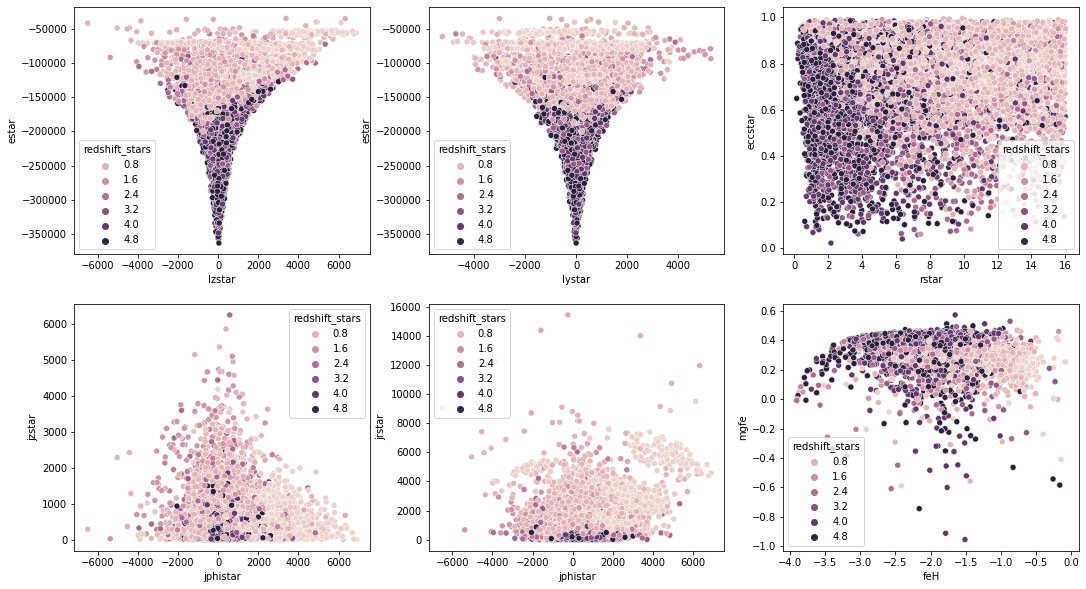

In [4]:
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
sns.scatterplot(data=df, ax=axes[0,0], x='lzstar', y='estar', hue='redshift_stars')
sns.scatterplot(data=df, ax=axes[0,1], x='lystar', y='estar', hue='redshift_stars')
sns.scatterplot(data=df, ax=axes[0,2], x='rstar', y='eccstar', hue='redshift_stars')
sns.scatterplot(data=df, ax=axes[1,0], x='jphistar', y='jzstar', hue='redshift_stars')
sns.scatterplot(data=df, ax=axes[1,1], x='jphistar', y='jrstar', hue='redshift_stars')
sns.scatterplot(data=df, ax=axes[1,2], x='feH', y='mgfe', hue='redshift_stars')

In [33]:
cluster1 = C_HDBSCAN(metric='manhattan', min_cluster_size=10, min_samples=4, cluster_selection_method='leaf', cluster_selection_epsilon=0.01)
cluster1.config()
# action diamond

In [34]:
selected_columns=['estar', 'c_lzstar', 'c_lxstar', 'c_lystar', 's_jzrstar', 'a_jzrstar', 'jphistar', 'eccstar', 'rstar', 'feH', 'mgfe', 'zmaxstar']
simple_selected_columns=['estar', 'lzstar', 'lxstar', 'lystar', 'jzstar', 'jrstar', 'jphistar', 'eccstar', 'rstar', 'feH', 'mgfe', 'zmaxstar']

In [35]:
cluster1.add_data(df, columns=simple_selected_columns)
labels = cluster1.fit()

In [36]:
def purity_score(y_true, y_pred):
    # compute contingency matrix (also called confusion matrix)
    contingency_matrix = metrics.cluster.contingency_matrix(y_true, y_pred)
    # return purity
    return np.sum(np.amax(contingency_matrix, axis=0)) / np.sum(contingency_matrix)

In [37]:
eval_IoU1 = ClusterEvalIoU(labels, df['cluster_id'].to_numpy(), IoU_thres=0.5)
print(eval_IoU1())
print(eval_IoU1.TP)
print(eval_IoU1.T)
print(eval_IoU1.P)
purity_score(df['cluster_id'].to_numpy(), labels)
# IoU metric makes no sense when the cutoff is below 0.5

(0.0, 0.0)
0
26
25


0.4085

In [38]:
eval_Mode = ClusterEvalMode(labels, df['cluster_id'].to_numpy())
print(eval_Mode())
print(eval_Mode.TP)
print(eval_Mode.T)
print(eval_Mode.P)

(0.0, 0.0)
0
26
25


In [18]:
AMI = sklearn.metrics.adjusted_mutual_info_score(df['cluster_id'].to_numpy(), labels)
RAND = sklearn.metrics.adjusted_rand_score(df['cluster_id'].to_numpy(), labels)
print(AMI, RAND)

0.05002523509365197 0.005969873516923408


In [131]:
df.drop(columns=['Unnamed: 0.2', 'Unnamed: 0', 'Unnamed: 0.1'])
df.index.is_unique

True

In [41]:
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
sns.kdeplot(data=df, ax=axes[0,0], x='c_lzstar', y='estar')
sns.kdeplot(data=df, ax=axes[0,1], x='c_lystar', y='estar')
sns.kdeplot(data=df, ax=axes[0,2], x='rstar', y='eccstar')
sns.kdeplot(data=df, ax=axes[1,0], x='jphistar', y='s_jzrstar')
sns.kdeplot(data=df, ax=axes[1,1], x='jphistar', y='a_jzrstar')
sns.kdeplot(data=df, ax=axes[1,2], x='feH', y='mgfe')

<AxesSubplot:xlabel='feH', ylabel='mgfe'>

Error in callback <function flush_figures at 0x128460ca0> (for post_execute):


KeyboardInterrupt: 

<AxesSubplot:xlabel='feH', ylabel='mgfe'>

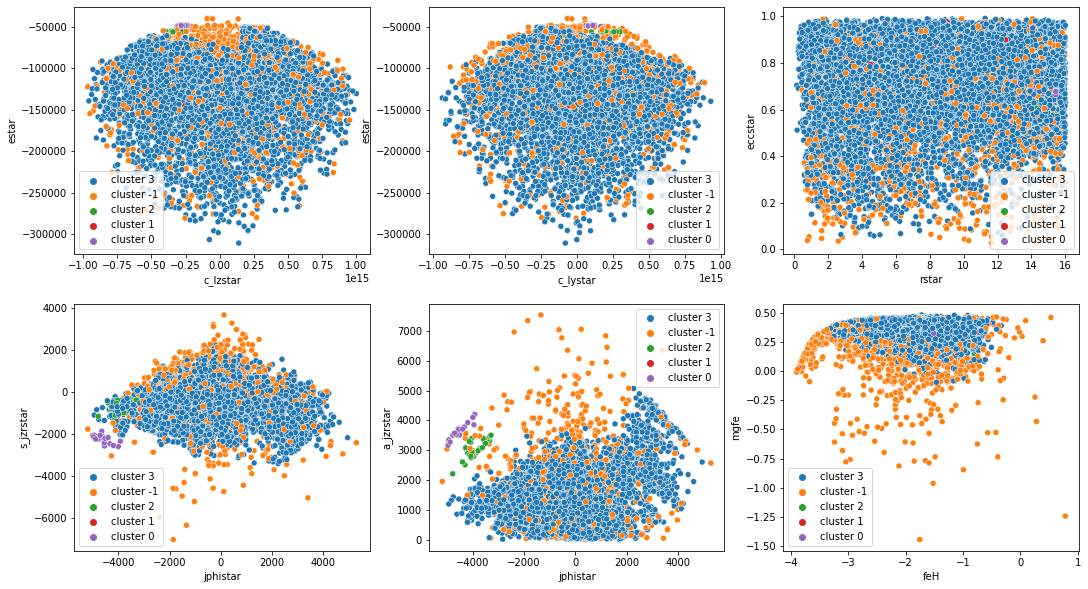

In [112]:
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
label_names = np.array([f'cluster {id}' for id in labels])
sns.scatterplot(data=df, ax=axes[0,0], x='c_lzstar', y='estar', hue=label_names)
sns.scatterplot(data=df, ax=axes[0,1], x='c_lystar', y='estar', hue=label_names)
sns.scatterplot(data=df, ax=axes[0,2], x='rstar', y='eccstar', hue=label_names)
sns.scatterplot(data=df, ax=axes[1,0], x='jphistar', y='s_jzrstar', hue=label_names)
sns.scatterplot(data=df, ax=axes[1,1], x='jphistar', y='a_jzrstar', hue=label_names)
sns.scatterplot(data=df, ax=axes[1,2], x='feH', y='mgfe', hue=label_names)

In [56]:
cluster2 = C_GaussianMixture(n_components=26)

In [57]:
cluster2.add_data(df, columns=simple_selected_columns)
labels2 = cluster2.fit(epoch = 100)

In [58]:
eval_IoU2 = ClusterEvalIoU(labels2, df['cluster_id'].to_numpy(), IoU_thres=0.3)
print(eval_IoU2())
print(eval_IoU2.TP)
print(eval_IoU2.T)
print(eval_IoU2.P)

(0.0, 0.0)
0
26
26


In [59]:
eval_Mode2 = ClusterEvalMode(labels2, df['cluster_id'].to_numpy())
print(eval_Mode2())
print(eval_Mode2.TP)
print(eval_Mode2.T)
print(eval_Mode2.P)

(0.15384615384615385, 0.15384615384615385)
4
26
26


In [60]:
purity = purity_score(df['cluster_id'].to_numpy(), labels2)
AMI = sklearn.metrics.adjusted_mutual_info_score(df['cluster_id'].to_numpy(), labels2)
RAND = sklearn.metrics.adjusted_rand_score(df['cluster_id'].to_numpy(), labels2)
print(purity, AMI, RAND)

0.5397 0.23984724945599692 0.08078137061368719


<AxesSubplot:xlabel='feH', ylabel='mgfe'>

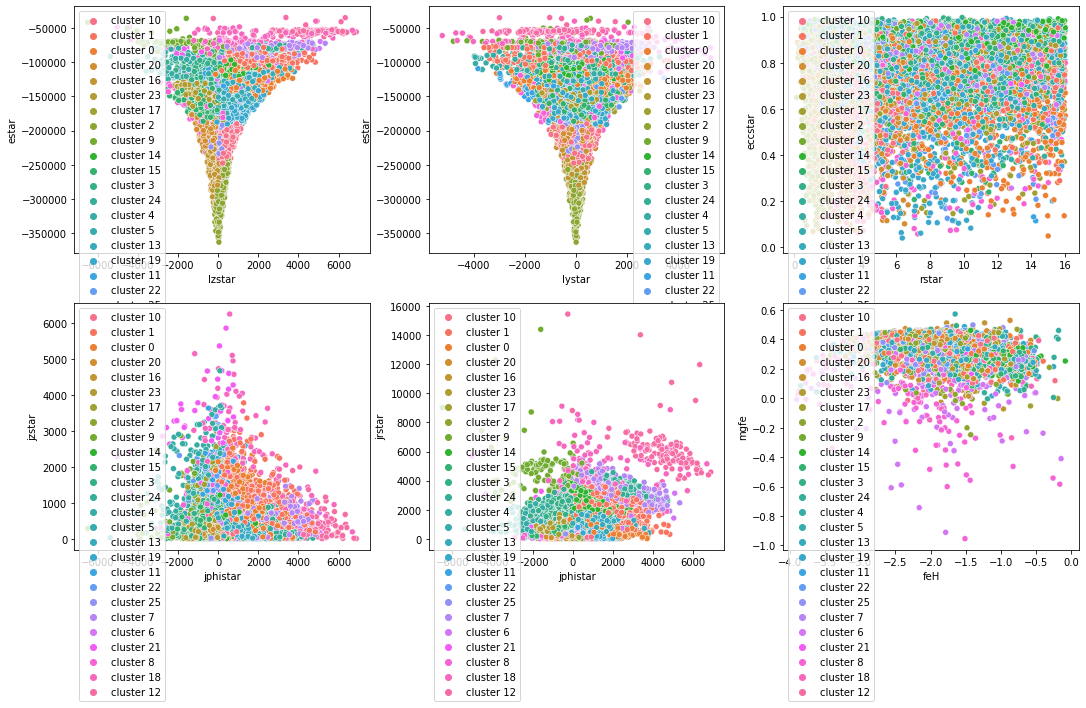

In [25]:
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
label_names = np.array([f'cluster {id}' for id in labels2])
sns.scatterplot(data=df, ax=axes[0,0], x='lzstar', y='estar', hue=label_names)
sns.scatterplot(data=df, ax=axes[0,1], x='lystar', y='estar', hue=label_names)
sns.scatterplot(data=df, ax=axes[0,2], x='rstar', y='eccstar', hue=label_names)
sns.scatterplot(data=df, ax=axes[1,0], x='jphistar', y='jzstar', hue=label_names)
sns.scatterplot(data=df, ax=axes[1,1], x='jphistar', y='jrstar', hue=label_names)
sns.scatterplot(data=df, ax=axes[1,2], x='feH', y='mgfe', hue=label_names)

In [26]:
from collections import Counter
print(Counter(df['cluster_id'].to_numpy()))

Counter({22: 3716, 15: 1495, 18: 1230, 20: 1124, 3: 616, 8: 587, 10: 288, 25: 176, 11: 135, 16: 133, 6: 127, 24: 100, 9: 64, 17: 61, 23: 35, 2: 23, 26: 16, 21: 13, 13: 10, 14: 10, 19: 9, 1: 9, 7: 8, 12: 7, 4: 6, 5: 2})


In [2]:
df = pd.read_hdf('../data/m12f_cluster_data_large_mass_large_cluster_v2.h5', key='star')
easy_small_clusters = [23, 2, 26, 4]
df = df.loc[np.isin(df['cluster_id'], easy_small_clusters)].copy()
df['lstar'] = np.linalg.norm([df['lzstar'].to_numpy(),df['lystar'].to_numpy(),df['lxstar'].to_numpy()],axis=0)
df['cluster_id_name'] = np.array([f'cluster {id}' for id in df['cluster_id'].to_numpy()])
df['c_lzstar'] = df['lzstar'].to_numpy()*np.abs(df['estar'].to_numpy())**2.3
df['c_lystar'] = df['lystar'].to_numpy()*np.abs(df['estar'].to_numpy())**2.3
df['c_lxstar'] = df['lxstar'].to_numpy()*np.abs(df['estar'].to_numpy())**2.3
df['s_jzrstar'] = df['jzstar'].to_numpy() - df['jrstar'].to_numpy() # mostly spherical because you can try squaring it
df['a_jzrstar'] = df['jzstar'].to_numpy() + df['jrstar'].to_numpy() # mostly spherical because you can try squaring it
df['rstar'] = np.linalg.norm([df['xstar'].to_numpy(),df['ystar'].to_numpy(),df['zstar'].to_numpy()],axis=0)

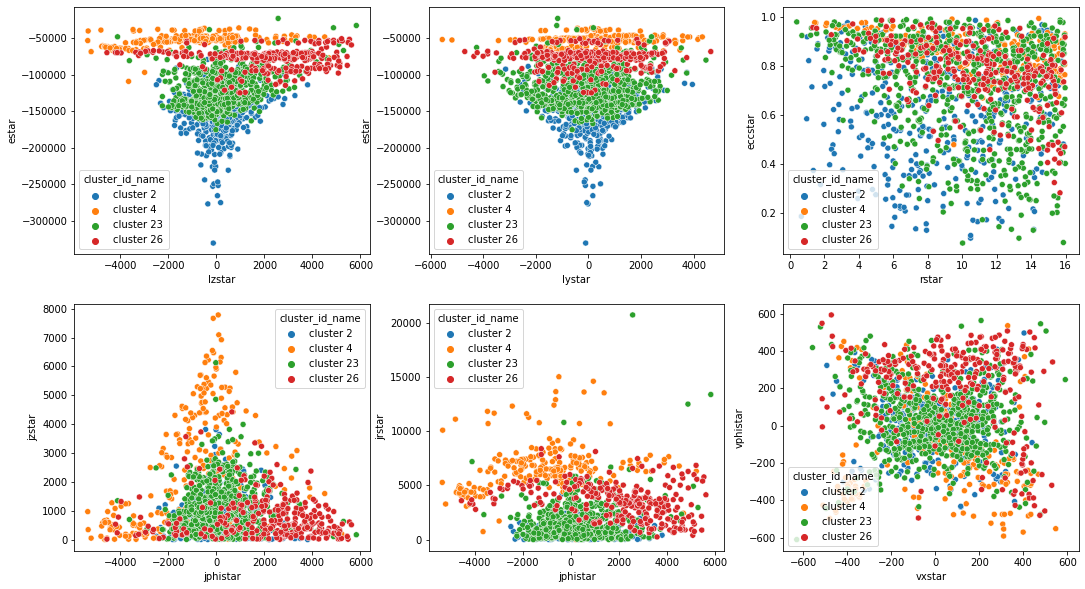

In [4]:
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
sns.scatterplot(data=df, ax=axes[0,0], x='lzstar', y='estar', hue='cluster_id_name')
sns.scatterplot(data=df, ax=axes[0,1], x='lystar', y='estar', hue='cluster_id_name')
sns.scatterplot(data=df, ax=axes[0,2], x='rstar', y='eccstar', hue='cluster_id_name')
sns.scatterplot(data=df, ax=axes[1,0], x='jphistar', y='jzstar', hue='cluster_id_name')
sns.scatterplot(data=df, ax=axes[1,1], x='jphistar', y='jrstar', hue='cluster_id_name')
sns.scatterplot(data=df, ax=axes[1,2], x='vxstar', y='vphistar', hue='cluster_id_name')
plt.show()

In [59]:
selected_columns=['estar', 'c_lzstar', 'c_lxstar', 'c_lystar', 's_jzrstar', 'a_jzrstar', 'jphistar', 'eccstar', 'rstar', 'feH', 'mgfe', 'zmaxstar']
#clusterer = C_HDBSCAN(metric='euclidean', min_cluster_size=40, min_samples=15, cluster_selection_method='leaf', cluster_selection_epsilon=0.01)
clusterer = C_GaussianMixture(n_components=6)
clusterer.add_data(df, columns=selected_columns)
clusters = clusterer.fit()

In [60]:
eval_IoU1 = ClusterEvalIoU(clusters, df['cluster_id'].to_numpy())
print(eval_IoU1())
print(eval_IoU1.TP)
print(eval_IoU1.T)
print(eval_IoU1.P)

(0.3333333333333333, 0.5)
2
4
6


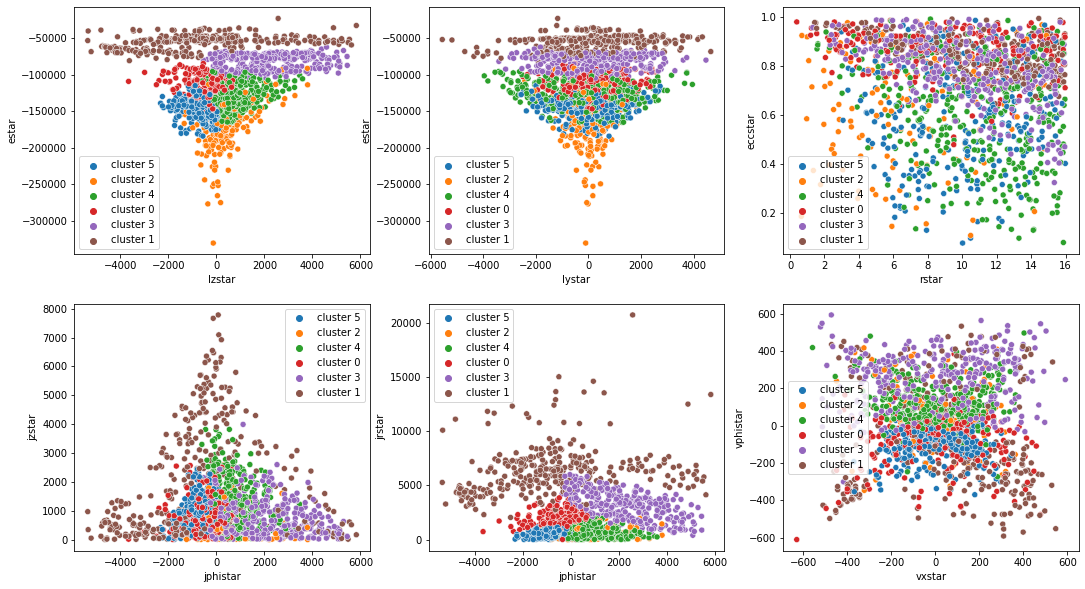

In [61]:
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
clusters_names = [f'cluster {label}' for label in clusters]
sns.scatterplot(data=df, ax=axes[0,0], x='lzstar', y='estar', hue=clusters_names)
sns.scatterplot(data=df, ax=axes[0,1], x='lystar', y='estar', hue=clusters_names)
sns.scatterplot(data=df, ax=axes[0,2], x='rstar', y='eccstar', hue=clusters_names)
sns.scatterplot(data=df, ax=axes[1,0], x='jphistar', y='jzstar', hue=clusters_names)
sns.scatterplot(data=df, ax=axes[1,1], x='jphistar', y='jrstar', hue=clusters_names)
sns.scatterplot(data=df, ax=axes[1,2], x='vxstar', y='vphistar', hue=clusters_names)
plt.show()

In [16]:
from collections import Counter
print(len(chosen_ids))
Counter(label_names[chosen_ids]).most_common()

8223


[('cluster -1', 5419),
 ('cluster 616', 42),
 ('cluster 580', 33),
 ('cluster 582', 31),
 ('cluster 585', 29),
 ('cluster 360', 28),
 ('cluster 622', 27),
 ('cluster 739', 24),
 ('cluster 574', 24),
 ('cluster 351', 23),
 ('cluster 492', 22),
 ('cluster 79', 21),
 ('cluster 493', 20),
 ('cluster 656', 19),
 ('cluster 665', 19),
 ('cluster 604', 19),
 ('cluster 612', 19),
 ('cluster 205', 18),
 ('cluster 650', 18),
 ('cluster 666', 18),
 ('cluster 684', 18),
 ('cluster 609', 18),
 ('cluster 531', 18),
 ('cluster 503', 17),
 ('cluster 754', 17),
 ('cluster 345', 17),
 ('cluster 623', 17),
 ('cluster 564', 17),
 ('cluster 683', 16),
 ('cluster 318', 16),
 ('cluster 527', 16),
 ('cluster 738', 16),
 ('cluster 710', 15),
 ('cluster 680', 15),
 ('cluster 619', 15),
 ('cluster 583', 15),
 ('cluster 649', 15),
 ('cluster 740', 15),
 ('cluster 523', 15),
 ('cluster 594', 15),
 ('cluster 10', 14),
 ('cluster 729', 14),
 ('cluster 692', 14),
 ('cluster 640', 14),
 ('cluster 615', 14),
 ('cluster 

In [17]:
from sklearn import metrics

In [18]:
metrics.rand_score(df['cluster_id'].to_numpy(), labels)

0.5088605084460291

In [13]:
eval_IoU1 = ClusterEvalIoU(labels, df['cluster_id'].to_numpy())
print(eval_IoU1())
print(eval_IoU1.TP)

(7.333333333333333, 0.44)
22


In [14]:
print(eval_IoU1.P)

3


### Now let's test out recursive clustering

In [27]:
clustera = C_HDBSCAN(metric='euclidean', min_cluster_size=2, min_samples=1, allow_single_cluster=True)
clusterb = C_HDBSCAN(metric='euclidean', min_cluster_size=2, min_samples=1, allow_single_cluster=True)
cluster2 = RecursiveCluster(subspace1_clusterer=clustera, subspace2_clusterer=clusterb)
cluster2.config()

In [28]:
cluster2.add_data(df, subspace1=['feH','mgfe'], subspace2=['feH','mgfe'])

In [29]:
labels2 = cluster2.fit()

[0 0 0 ... 0 0 0]
[29429   166    -1 ... 34129 16868 37740]
44066
44066
[   -1   166    -1 ...    -1    -1 37740]
[   -1   166    -1 ...    -1    -1 37740]
44066
44066


In [18]:
print(labels2)
label2_names = np.array([f'cluster {label}' for label in labels2])
labels_sorted = np.sort(labels2)
print(labels_sorted)

[   -1    -1  7579 ... 43818    -1 48470]
[   -1    -1    -1 ... 51662 51663 51663]


In [19]:
chosen_ids = np.argwhere(df['cluster_id'].isin(chosen_cluster_ids).to_numpy())[:,0]

In [20]:
#sns.scatterplot(data=df.iloc[chosen_ids], x='feH', y='mgfe', hue=label2_names[chosen_ids])

In [21]:
metrics.rand_score(df['cluster_id'].to_numpy(), labels2)

0.7065505895246961

In [22]:
metrics.rand_score(labels, labels2)

0.1470609716211652

In [23]:
eval_IoU1 = ClusterEvalIoU(labels, df['cluster_id'].to_numpy())
print(eval_IoU1())

(7.333333333333333, 0.44)


In [24]:
eval_IoU2 = ClusterEvalIoU(labels2, df['cluster_id'].to_numpy())
print(eval_IoU2())

(1.9355463079454177e-05, 0.02)


In [25]:
eval_IoU3 = ClusterEvalIoU(labels, labels2)
print(eval_IoU3())

(71.33333333333333, 0.004142069099003194)


### Now let's test HDBSCAN + GMM

In [5]:
clustera = C_HDBSCAN(metric='euclidean', min_cluster_size=2, min_samples=1, allow_single_cluster=True)
clusterb = C_GaussianMixture(n_components=1)
cluster3 = RecursiveCluster(subspace1_clusterer=clustera, subspace2_clusterer=clusterb)
cluster3.config()
cluster3.add_data(df, subspace1=['feH','mgfe'], subspace2=['feH','mgfe'])

In [6]:
labels3 = cluster3.fit()

[0 0 0 ... 0 0 0]
[29429   166    -1 ... 34129 16868 37740]
44066
44066
[29429   166    -1 ... 34129 16868 37740]
[   -1   166    -1 ...    -1    -1 37740]
44066
44066
[   -1   166    -1 ...    -1    -1 37740]
[   -1   166    -1 ...    -1    -1 37740]
44066
44066


In [9]:
metrics.rand_score(df['cluster_id'].to_numpy(), labels3)

0.681046828478812

In [10]:
eval_IoU4 = ClusterEvalIoU(labels3, df['cluster_id'].to_numpy())
print(eval_IoU4())

(2.26927179068237e-05, 0.02)
